In [1]:
import warnings
warnings.filterwarnings('ignore')

## I. Import the Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

from sklearn.compose import ColumnTransformer

from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

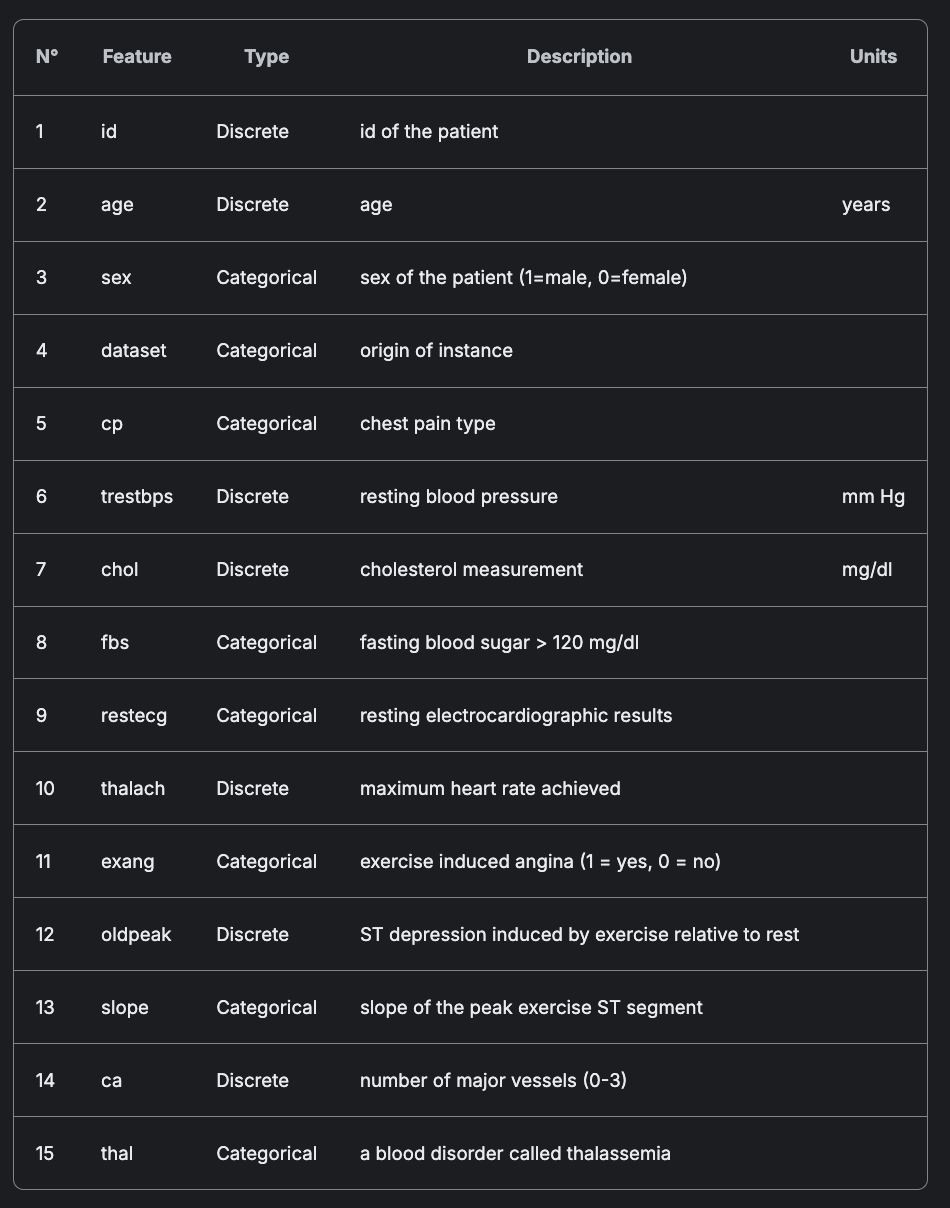

## II. Import data

In [3]:
heart = pd.read_csv('heart_disease.csv')
submission = pd.read_csv('sample.csv')

heart.head(8)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal
5,5,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal
6,6,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal
7,7,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal


## III. Exploratory data analysis

In [4]:
heart.shape

(920, 15)

In [5]:
heart.dtypes

id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
dtype: object

In [6]:
heart.select_dtypes('object').nunique()

sex        2
dataset    4
cp         4
fbs        2
restecg    3
exang      2
slope      3
thal       3
dtype: int64

In [7]:
heart.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64

<Axes: title={'center': 'Heartmap of Missing Values'}>

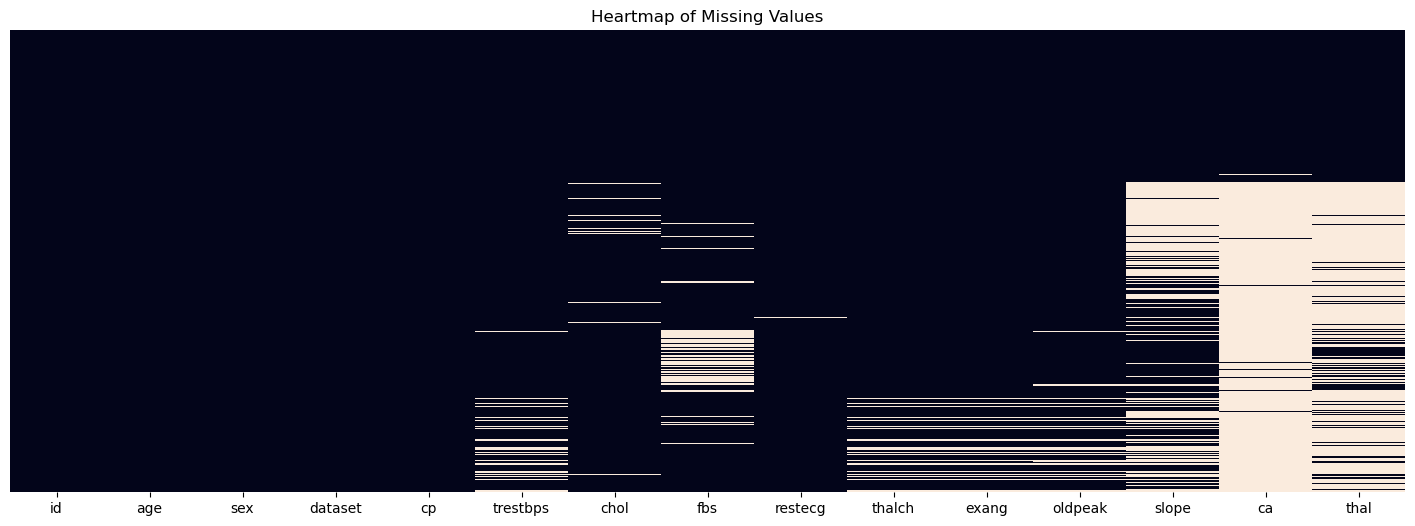

In [8]:
plt.figure(figsize=(18, 6))
plt.title('Heartmap of Missing Values')
sns.heatmap(heart.isnull(), yticklabels=False, cbar=False)

In [9]:
submission.id = heart['id']

In [10]:
heart.drop('id', axis=1, inplace=True)

In [11]:
num_features = heart.select_dtypes(np.number)
cat_features = heart.select_dtypes(object)

In [12]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features.columns),
    ('cat', cat_transformer, cat_features.columns)
])

In [13]:
X_preprocessed = preprocessor.fit_transform(heart)

## IV. Select Models

### 4.1. KMeans

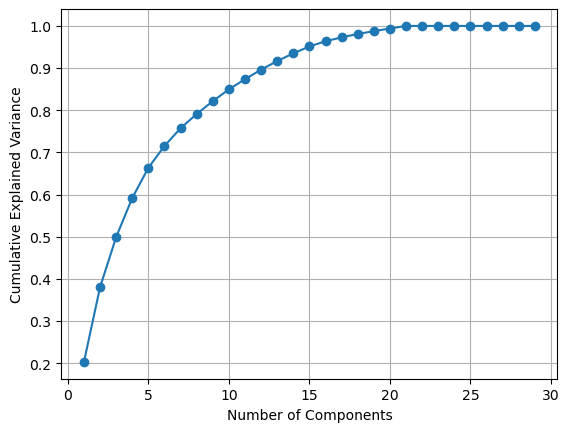

In [14]:
pca = PCA().fit(X_preprocessed)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [15]:
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(X_preprocessed)

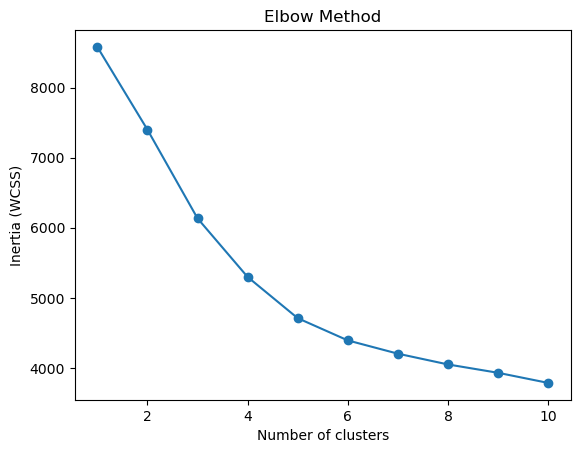

In [16]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

# Plot elbow
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.show()

In [17]:
for k in range(2, 11):
    model = Pipeline([
        ('preprocessing', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('kmeans', KMeans(n_clusters=k, random_state=42))
    ])
    
    model.fit(heart)
    
    # Get PCA-reduced data
    reduced_data = model.named_steps['pca'].transform(
        model.named_steps['preprocessing'].transform(heart)
    )
    
    labels = model.named_steps['kmeans'].labels_
    score = silhouette_score(reduced_data, labels)
    print(f"k = {k}, Silhouette Score = {score:.3f}")

k = 2, Silhouette Score = 0.177
k = 3, Silhouette Score = 0.175
k = 4, Silhouette Score = 0.190
k = 5, Silhouette Score = 0.201
k = 6, Silhouette Score = 0.186
k = 7, Silhouette Score = 0.178
k = 8, Silhouette Score = 0.171
k = 9, Silhouette Score = 0.162
k = 10, Silhouette Score = 0.165


### 4.2. DBSCAN

In [19]:
eps_values = np.linspace(0.1, 1, 10)

for eps_value in eps_values:
    model = Pipeline([
        ('preprocessing', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('db', DBSCAN(eps=eps_value))
    ])
    
    model.fit(heart)
    
    # Get reduced data after preprocessing and PCA
    reduced_data = model.named_steps['pca'].transform(
        model.named_steps['preprocessing'].transform(heart)
    )
    
    labels = model.named_steps['db'].labels_
    
    # Exclude noise (-1) for silhouette score
    mask = labels != -1
    if len(set(labels[mask])) > 1:
        score = silhouette_score(reduced_data[mask], labels[mask])
        print(f"eps = {eps_value:.2f}, Silhouette Score = {score:.3f}, Clusters = {len(set(labels)) - (1 if -1 in labels else 0)}")
    else:
        print(f"eps = {eps_value:.2f}, Not enough clusters for silhouette score (clusters = {len(set(labels))})")

eps = 0.10, Not enough clusters for silhouette score (clusters = 1)
eps = 0.20, Not enough clusters for silhouette score (clusters = 1)
eps = 0.30, Not enough clusters for silhouette score (clusters = 1)
eps = 0.40, Not enough clusters for silhouette score (clusters = 1)
eps = 0.50, Not enough clusters for silhouette score (clusters = 1)
eps = 0.60, Silhouette Score = 0.572, Clusters = 2
eps = 0.70, Silhouette Score = 0.467, Clusters = 5
eps = 0.80, Silhouette Score = 0.450, Clusters = 5
eps = 0.90, Silhouette Score = 0.369, Clusters = 7
eps = 1.00, Silhouette Score = 0.287, Clusters = 10


### 4.3. AgglomerativeClustering

In [20]:
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(reduced_data)
    score = silhouette_score(reduced_data, labels)
    print(f"n_clusters={k}, silhouette_score={score:.3f}")

n_clusters=2, silhouette_score=0.376
n_clusters=3, silhouette_score=0.268
n_clusters=4, silhouette_score=0.203
n_clusters=5, silhouette_score=0.186
n_clusters=6, silhouette_score=0.170
n_clusters=7, silhouette_score=0.158
n_clusters=8, silhouette_score=0.155
n_clusters=9, silhouette_score=0.151
n_clusters=10, silhouette_score=0.146


In [21]:
pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('db', DBSCAN(eps=0.6))
])

pipe.fit(heart)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object'))])),
                ('pca', PCA(n_components=0.95)), ('db', DBSCAN(eps=0.6))])

In [22]:
labels = pipe.named_steps['db'].labels_

np.unique(labels)

array([-1,  0,  1])

### 4.4. Visualization

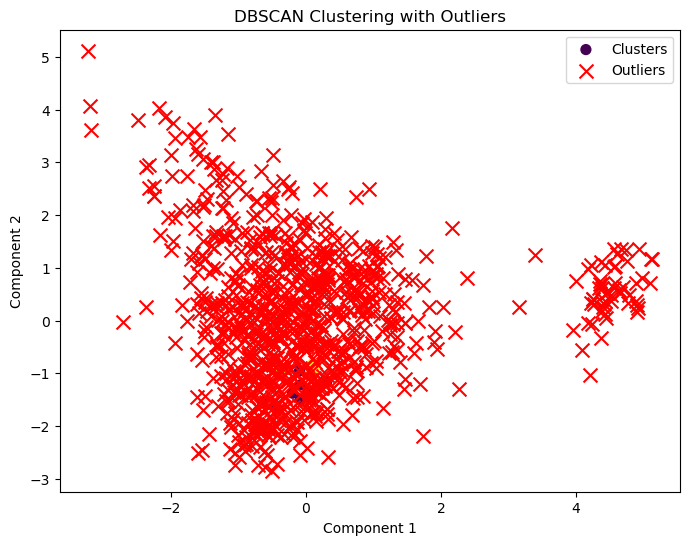

In [23]:
labels = pipe.named_steps['db'].labels_

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Scatter plot of core samples and outliers
# Core samples are the points with labels >= 0
plt.scatter(reduced_data[labels != -1, 0], reduced_data[labels != -1, 1], 
            c=labels[labels != -1], cmap='viridis', label='Clusters', s=50)

# Outliers are the points with label -1
plt.scatter(reduced_data[labels == -1, 0], reduced_data[labels == -1, 1], 
            color='red', marker='x', label='Outliers', s=100)

# Add labels and legend
plt.title('DBSCAN Clustering with Outliers')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()

plt.show()

In [27]:
submission

,id,cluster
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
294,294,0
295,295,0
296,296,0
297,297,0


In [26]:
submission.cluster = labels

ValueError: Length of values (920) does not match length of index (299)